4 2


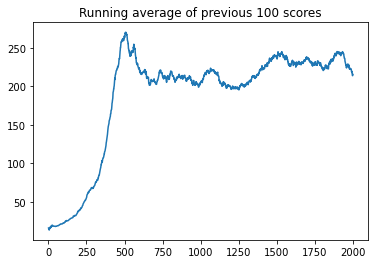

In [1]:
CUDA_LAUNCH_BLOCKING=1
import torch as T
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import numpy as np

###################################################
# Actor Critic mmodel with discrete actions
###################################################

class Critic(nn.Module):
    def __init__(self, dim_state ,h1, h2, alpha=1e-4 ):
        super(Critic, self).__init__()
        
        self.dim_state = dim_state
        self.dim_action = dim_action
        
        self.linear1 = nn.Linear(dim_state, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2,1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output
    
class Actor(nn.Module):
    def __init__(self, dim_state, dim_action, alpha, fc1, fc2,):
        super(Actor, self).__init__()
        self.lr = alpha
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.fc1 = fc1
        self.fc2 = fc2
        
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc2, dim_action)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-4)
        self.to(self.device)
    
    def forward(self,state):
        output = state.to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output 
        
class Agent():
    def __init__(self, env, dim_state, dim_action, alpha, fc1, fc2, maxm_Iters=50, gamma=0.99):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.gamma = gamma
        self.maxm_Iters = maxm_Iters
        
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.critic = Critic(dim_state,fc1, fc2)
        self.actor = Actor(dim_state, dim_action, alpha, fc1, fc2)
        
    def plot_learning_curve(self, x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
    
    
    def train(self):
      
        reward_list = []
        for i in range(self.maxm_Iters):
            state = env.reset()
            total_reward = 0
            done= False
            
            while not done:
                self.critic.train()
                self.actor.train()
        
                self.critic.zero_grad()
                self.actor.zero_grad()
              
                probs = F.softmax(self.actor(T.tensor(state).float()), dim=0)

                m = Categorical(probs)
                action = m.sample().to(self.device)

                state_next, reward, done, _ = env.step(action.item())
                total_reward +=reward
           
                target = torch.tensor(reward) + self.gamma * self.critic(T.tensor(state_next).float())*(1-int(done))
                state_value = self.critic(T.tensor(state).float())
                advantage = target - state_value
         
                ## Loss for critic
                loss_critic = advantage**2
                
                ## Loss for actor
                loss_actor = -m.log_prob(action) * advantage
                #loss_actor = (-m.log_prob(T.tensor(action_batch)) * advantage)
                
                (loss_critic + loss_actor).backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
                state = state_next
            reward_list.append(total_reward)
            
        x = [i+1 for i in range(self.maxm_Iters)]
        self.plot_learning_curve(x, reward_list)
        
if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    #env = gym.make('MountainCar-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.n
    print (dim_state,dim_action )
    
    agent = Agent(env,dim_state,dim_action, 1e-5, 256, 256, maxm_Iters=2000)
    agent.train()
        

### For Pure random actions

Actor(
  (linear1): Linear(in_features=4, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=2, bias=True)
)
[216.0, 191.0, 206.0, 223.0, 266.0, 151.0, 411.0, 258.0, 350.0, 411.0, 285.0, 341.0, 199.0, 349.0, 144.0, 303.0, 200.0, 253.0, 296.0, 493.0, 134.0, 169.0, 339.0, 188.0, 249.0, 304.0, 201.0, 216.0, 163.0, 168.0, 341.0, 313.0, 399.0, 195.0, 270.0, 400.0, 206.0, 274.0, 244.0, 379.0, 164.0, 254.0, 139.0, 161.0, 419.0, 206.0, 216.0, 142.0, 180.0, 251.0, 173.0, 176.0, 226.0, 318.0, 158.0, 186.0, 134.0, 159.0, 427.0, 248.0, 143.0, 210.0, 365.0, 293.0, 442.0, 306.0, 231.0, 127.0, 135.0, 176.0, 167.0, 232.0, 209.0, 286.0, 166.0, 232.0, 301.0, 129.0, 164.0, 180.0, 173.0, 387.0, 173.0, 311.0, 175.0, 435.0, 253.0, 217.0, 144.0, 156.0, 198.0, 241.0, 330.0, 179.0, 161.0, 279.0, 269.0, 127.0, 241.0, 379.0, 265.0, 178.0, 153.0, 303.0, 340.0, 210.0, 183.0, 348.0, 150.0, 128.0, 461.0, 188.0, 241.0, 305.0

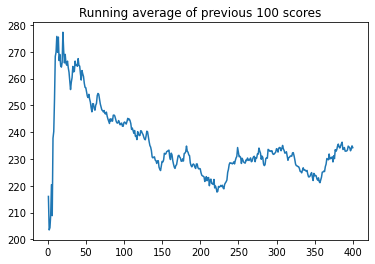

In [5]:
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt

random=False
max_iters = 400
model = agent.actor
print(model)

rewards_list=[]
for i in range(max_iters):
    model.eval()
    state = env.reset()
    done=False
    rewards = 0
    
    while not done:
        if not random:
            #For deepQ evaluation
            #actions = model(torch.tensor(state).float())
            #best = torch.argmax(actions)               
            #action = agent.select_actions_epsilon(best.item())
            
            probs = F.softmax(model(T.tensor(state).float()), dim=0)
            m = Categorical(probs)
            action = m.sample().item()
                
        else:
            action = env.action_space.sample()
        
        state_new, reward, done, _ = env.step(action)
        rewards+=reward
        
        state = state_new
        
    rewards_list.append(rewards)
print(rewards_list)           
x = [i+1 for i in range(max_iters)]
agent.plot_learning_curve(x, rewards_list)
   